In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# import train_test_split
from sklearn.model_selection import train_test_split

from tqdm import tqdm


# Models
1) Autoencoder : Train autoencoder model with normal(unfaulted) data. It can be used for fault detection
2) Supervised Auto encoder: Train with all data along with type of failure labels. It is used for fault detection and diagnosis

# Load Dataset

In [2]:
dataset = pd.read_csv('building_fault_detection.csv')
dataset.head()

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
0,11-09-2017 00:00,72.29,NaN,NaN,81.11,78.56,76.38,1,0.1,0.0,1.0,-0.04,0.0,0.23,0,1
1,11-09-2017 00:01,72.30,NaN,NaN,81.11,78.56,76.39,1,0.1,0.0,1.0,-0.04,0.0,0.23,0,1
2,11-09-2017 00:02,72.37,NaN,NaN,81.09,78.56,76.38,1,0.1,0.0,1.0,-0.04,0.0,0.22,0,1
3,11-09-2017 00:03,72.29,NaN,NaN,81.06,78.51,76.38,1,0.1,0.0,1.0,-0.04,0.0,0.22,0,1
4,11-09-2017 00:04,71.82,NaN,NaN,81.05,78.41,76.37,1,0.1,0.0,1.0,-0.04,0.0,0.24,0,1


# Data preprocessing

Apply data pre-processing steps for data

In [3]:
# Handle missing values. Drop rows with NaN
df_clean = dataset.dropna(axis='index') # drop rows with NaN
# fix space padding in column names
columns = [c.strip() for c in df_clean.columns]
df_clean.columns = columns
# Convert Datetime to datetime object
df_clean['Datetime']= pd.to_datetime(df_clean['Datetime'], format='%d-%m-%Y %H:%M')
# Convert all columns to numeric
df_clean['AHU: Outdoor Air Temperature'] = pd.to_numeric(df_clean['AHU: Outdoor Air Temperature'], errors='coerce')
df_processed = df_clean.copy()

# drop timestamps,supplyfan status to create a processed dataset
df_clean = df_clean.drop(columns=['Datetime','AHU: Supply Air Fan Status'])
# Create training dataset by selecting the rows where no columns occurred
df_normal = df_clean[df_clean['Fault Detection Ground Truth'] == 0]
df_fault = df_clean[df_clean['Fault Detection Ground Truth'] == 1]
# drop the fault detection column
df_normal = df_normal.drop(columns=['Fault Detection Ground Truth'])
df_fault = df_fault.drop(columns=['Fault Detection Ground Truth'])

/tmp/ipykernel_731164/1940197879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Datetime']= pd.to_datetime(df_clean['Datetime'], format='%d-%m-%Y %H:%M')
/tmp/ipykernel_731164/1940197879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['AHU: Outdoor Air Temperature'] = pd.to_numeric(df_clean['AHU: Outdoor Air Temperature'], errors='coerce')


In [4]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=5, hidden_size=3, dropout=0.2, device='cpu'):
        super(Autoencoder, self).__init__()
        self.device= device
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            # nn.Sigmoid(),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(hidden_size),
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(input_size),
            # nn.Linear(input_size, input_size)
        )
        print("Device:",self.device)
    
    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def batch_eval(self, batch):
        x = batch
        x = x.to(self.device)
        x_hat = self.forward(x)
        loss = ((x-x_hat)**2).mean()
        return loss


        

In [5]:
# implement early stopping mechanism to stop the training loop incase there is no significant
# change in validation loss
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # logic for early stopping
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop

def train_epoch(model, dataloader, optimizer):
    running_loss = 0.0
    model.train()
    # for i, data in tqdm(enumerate(dataloader)):
    for i, data in enumerate(dataloader):
        loss = model.batch_eval(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def train_model(model, dataloader, valid_dataloader, optimizer, num_epochs=10, early_stopping=None):
    train_losses = []
    val_losses = []
    # val_data = torch.tensor(df_normal_test.values, dtype=torch.float32)
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, dataloader, optimizer)
        train_losses.append(epoch_loss)
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for val_data in valid_dataloader:
                val_loss = model.batch_eval(val_data)
                running_vloss += val_loss.item()
        val_loss = running_vloss / len(valid_dataloader)    
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        if early_stopping is not None:
            if early_stopping(val_loss):
                print("Early Stopping")
                break

        # keep track of best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            best_epoch = epoch
            

    return train_losses, val_losses, best_model, best_epoch, best_val_loss




In [6]:
# Create dataset for training autoencoder
class BuildingDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx].values, dtype=torch.float32)
        
# train, test splits
df_normal_train, df_normal_test = train_test_split(df_normal, test_size=0.2, random_state=42)

normal_dataset = BuildingDataset(df_normal_train)
valid_dataset = BuildingDataset(df_normal_test)
fault_dataset = BuildingDataset(df_fault)

# Create dataloader
norm_size = len(df_normal)
batch_size = int(norm_size/10)
print(f'Batch size: {batch_size}')
normal_loader = DataLoader(normal_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
fault_loader = DataLoader(fault_dataset, batch_size=batch_size, shuffle=False)


Batch size: 575


Initialize the model with config parameters

In [7]:
device=None
# select device for model training
if torch.cuda.is_available():
    device = torch.device(f"cuda:{torch.cuda.current_device()}")
    print(f'Using GPU: {torch.cuda.get_device_name()}')
else:
    device = torch.device("cpu")
    print('Using CPU')

inputs = df_normal.shape[1]
hidden = 300  # number of hidden units
dropout = 0.2

loss_fn = nn.MSELoss()
ae_mdl = Autoencoder(input_size=inputs, hidden_size=hidden, dropout=dropout, device = device)
ae_mdl.to(device)
optimizer = optim.Adam(ae_mdl.parameters(), lr=0.01)
print(ae_mdl)

Using GPU: NVIDIA RTX A3000 Laptop GPU
Device: cuda:0
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=13, bias=True)
    (1): ReLU()
    (2): Linear(in_features=13, out_features=300, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=13, bias=True)
  )
)


Invoke model training and plot train and valid losses

Epoch 1/200, Train Loss: 2100.1141, Val Loss: 1880.6173
Epoch 2/200, Train Loss: 1844.2666, Val Loss: 1379.9788
Epoch 3/200, Train Loss: 1347.8696, Val Loss: 667.5831
Epoch 4/200, Train Loss: 635.8011, Val Loss: 280.6099
Epoch 5/200, Train Loss: 115.2387, Val Loss: 13.0420
Epoch 6/200, Train Loss: 33.5690, Val Loss: 48.4140
Epoch 7/200, Train Loss: 44.8033, Val Loss: 121.4513
Epoch 8/200, Train Loss: 13.2930, Val Loss: 5.8841
Epoch 9/200, Train Loss: 11.7749, Val Loss: 4.5747
Epoch 10/200, Train Loss: 9.1784, Val Loss: 9.5595
Epoch 11/200, Train Loss: 6.4085, Val Loss: 3.7162
Epoch 12/200, Train Loss: 6.1818, Val Loss: 2.8549
Epoch 13/200, Train Loss: 5.7592, Val Loss: 3.7002
Epoch 14/200, Train Loss: 4.9663, Val Loss: 3.1504
Epoch 15/200, Train Loss: 5.2457, Val Loss: 2.4822
Epoch 16/200, Train Loss: 4.7636, Val Loss: 4.2711
Epoch 17/200, Train Loss: 4.0725, Val Loss: 2.2512
Epoch 18/200, Train Loss: 4.0435, Val Loss: 1.8908
Epoch 19/200, Train Loss: 4.4208, Val Loss: 1.7696
Epoch 20/

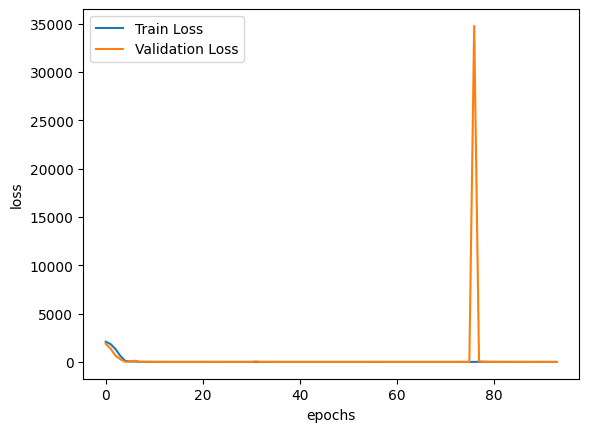

In [8]:
# early_stopping = EarlyStopping(patience=10, delta=0.001)
train_losses,valid_losses, best_model, best_epoch, best_val_loss = train_model(ae_mdl, normal_loader, 
                                                                valid_loader, optimizer, 
                                                                num_epochs=200, 
                                                                early_stopping=EarlyStopping(patience=20, delta=0.001))
print(f'Best epoch: {best_epoch}, Best Validation Loss: {best_val_loss}')
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(valid_losses)),valid_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [9]:
# save the best model
torch.save(best_model, 'best_autoencoder.pth')
print('Model saved as best_autoencoder.pth')

Model saved as best_autoencoder.pth


In [10]:
# load the best model
best_model = Autoencoder(input_size=inputs, hidden_size=hidden, dropout=dropout, device=device)
best_model.load_state_dict(torch.load('best_autoencoder.pth'))
best_model.to(device)

Device: cuda:0


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=13, bias=True)
    (1): ReLU()
    (2): Linear(in_features=13, out_features=300, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=13, bias=True)
  )
)

Plotting histogram of reconstruction errors

Make inferences on training data

Loss Calculation: 100%|██████████| 17/17 [00:00<00:00, 28.56it/s]


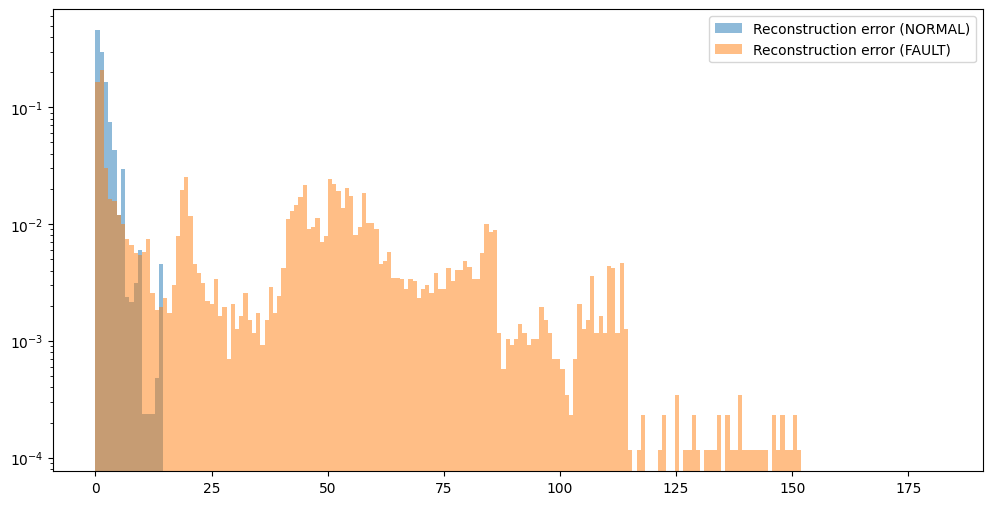

In [11]:
def evaluate_model(model, dataloader):
    best_model = model
    # evaluate the model
    best_model.eval()

    # eval_dataset = df_normal
    # eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    # losses = dict()
    # loss_features = []
    loss_samples = []
    for i, data in enumerate(tqdm(dataloader, desc=f"Loss Calculation")):
        y_true = data.to(device)
        with torch.no_grad():
            y_pred = best_model(data)

        loss = (y_true-y_pred)**2
        loss_samples.extend(loss.mean(dim=1).cpu().tolist())
    # print(loss)
    return loss_samples

normal_loss = evaluate_model(best_model, normal_loader)
fault_loss = evaluate_model(best_model, fault_loader)
max_train = max(normal_loss)
max_test = max(fault_loss)
max_range = max([max_train, max_test])*1.2
RANGE = [0,max_range]
BINS = 200
LOG = True

plt.figure(figsize=(12,6))
plt.hist(normal_loss, bins=BINS, log=LOG, alpha=0.5, range=RANGE, density=True, label="Reconstruction error (NORMAL)")
plt.hist(fault_loss, bins=BINS, log=LOG, alpha=0.5, range=RANGE, density=True, label="Reconstruction error (FAULT)")
plt.legend()
plt.show()
    

# Supervised Autoencoder

The supervised autoencoder architecture is created as given in *A data-driven fault detection and diagnosis scheme for air handling units in building HVAC systems considering undefined states*. 

Pre-proc data and Prepare dataset

### Dataset Labelling
Label dataset as per table reference

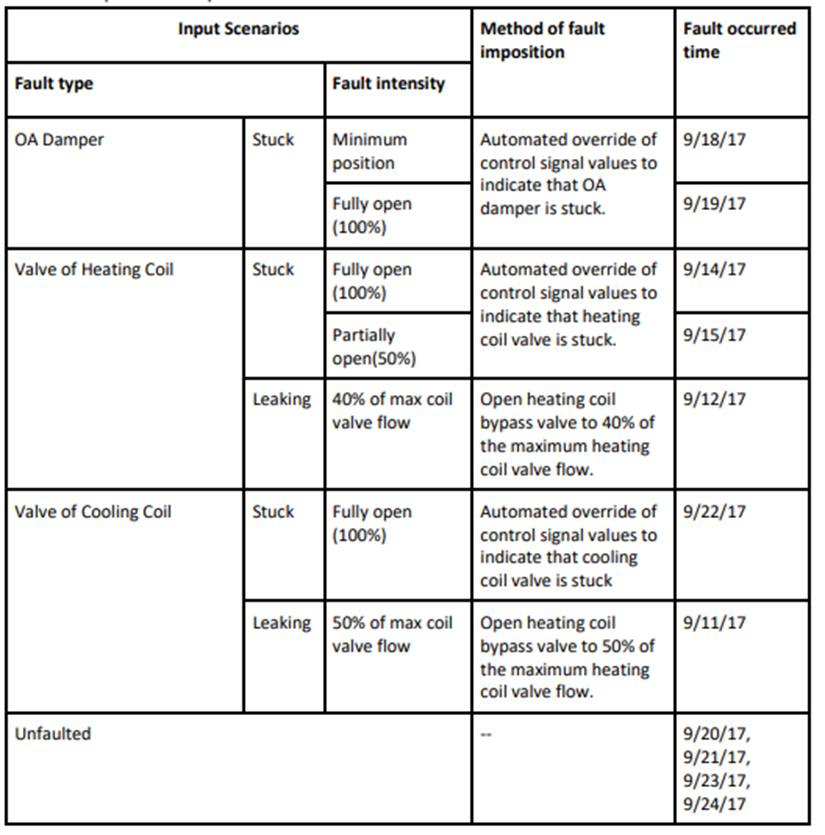
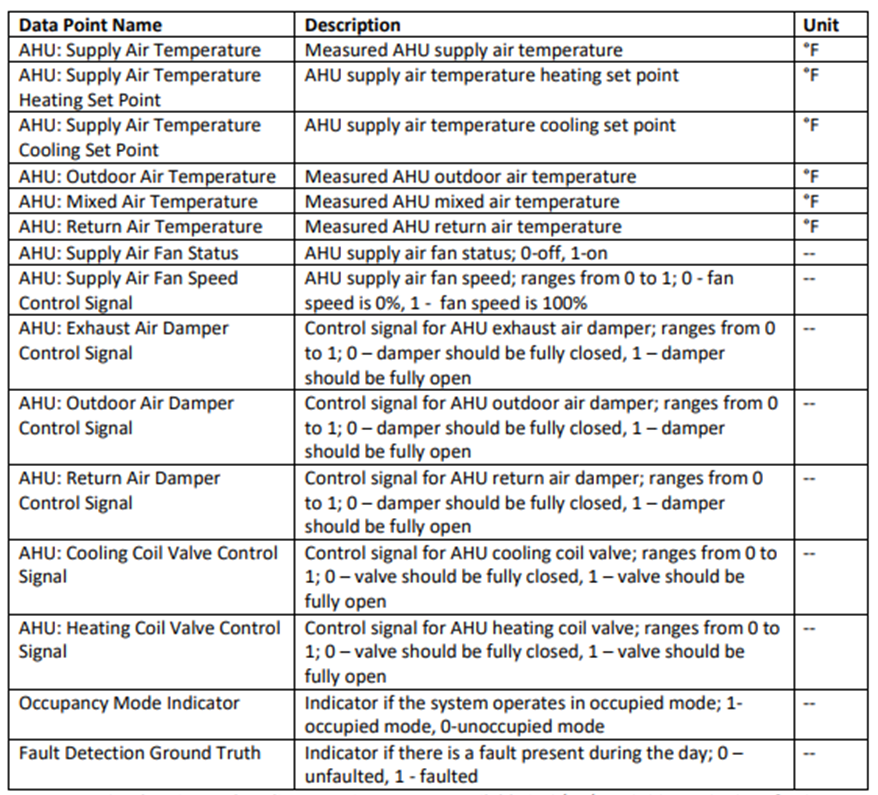

In [12]:
df_processed['Labels']=pd.NA
# unfaulted normal days to 0
df_processed.loc[df_processed['Datetime'].dt.day == 20,'Labels'] = 0
df_processed.loc[df_processed['Datetime'].dt.day == 21,'Labels'] = 0
df_processed.loc[df_processed['Datetime'].dt.day == 23,'Labels'] = 0
df_processed.loc[df_processed['Datetime'].dt.day == 24,'Labels'] = 0
# cooling coil fault 1
df_processed.loc[df_processed['Datetime'].dt.day == 11,'Labels'] = 1
df_processed.loc[df_processed['Datetime'].dt.day == 22,'Labels'] = 1
# heating coil fault 2
df_processed.loc[df_processed['Datetime'].dt.day == 12,'Labels'] = 2
df_processed.loc[df_processed['Datetime'].dt.day == 14,'Labels'] = 2
df_processed.loc[df_processed['Datetime'].dt.day == 15,'Labels'] = 2
# oa damper fault 3
df_processed.loc[df_processed['Datetime'].dt.day == 18,'Labels'] = 3
df_processed.loc[df_processed['Datetime'].dt.day == 1,'Labels'] = 3

df_processed['Labels'] = df_processed['Labels'].astype('category')

# drop the datetime column and Supply fan status column
df_processed = df_processed.drop(columns=['Datetime','AHU: Supply Air Fan Status'])

In [13]:
# create training set with labels 0, 1, and 2
df_train = df_processed[df_processed['Labels'].isin([0,1,2])]
df_test = df_processed[df_processed['Labels'].isin([3])]

# create train and valid splits, equally distributing the labels across the splits
df_train_0 = df_train[df_train['Labels']==0]
df_train_1 = df_train[df_train['Labels']==1]
df_train_2 = df_train[df_train['Labels']==2]

df_train_0, df_valid_0 = train_test_split(df_train_0, test_size=0.2, random_state=42)
df_train_1, df_valid_1 = train_test_split(df_train_1, test_size=0.2, random_state=42)
df_train_2, df_valid_2 = train_test_split(df_train_2, test_size=0.2, random_state=42)

df_train = pd.concat([df_train_0, df_train_1, df_train_2])

df_valid = pd.concat([df_valid_0, df_valid_1, df_valid_2])

In [14]:
# Create dataset for training autoencoder
class BuildingDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx, :-1].values, self.df.iloc[idx, -1]
        # return self.df.iloc[idx].values

# model definition
class SupervisedAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, nlabels, dropout, device='cpu'):
        super(SupervisedAutoEncoder, self).__init__()
        self.device = device
        self.encoder = nn.Sequential(
            nn. Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size)
        )
        self.classifer = nn.Sequential(
            nn.Linear(hidden_size, nlabels),
            # nn.Softmax()
        )

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)
        y = self.classifer(x)
        x = self.decoder(x)
        return x, y

    def batch_eval(self, batch, labels):
        x = batch
        y = labels
        x = x.to(self.device)
        y = y.to(self.device)
        x_hat, y_hat = self.forward(x)
        loss = ((x-x_hat)**2).mean()
        # y = y.type(torch.LongTensor)
        # y_hat = y_hat.type(torch.LongTensor)
        class_loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss, class_loss


# implement early stopping mechanism to stop the training loop incase there is no significant
# change in validation loss
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # logic for early stopping
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop

def train_epoch(model, dataloader, optimizer):
    running_loss = 0.0
    running_class_loss = 0.0
    model.train()
    for i, data in enumerate(dataloader):
        loss, class_loss = model.batch_eval(torch.tensor(data[0], dtype=torch.float32)
                                        ,torch.tensor(data[1]).type(torch.LongTensor))
        total_loss = loss + class_loss
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        running_class_loss += class_loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_class_loss = running_class_loss / len(dataloader)
    return epoch_loss, epoch_class_loss

def eval_metrics(y_true, y_pred):
    # using sklearn metrics 
    # calculate precision, recall & f1 score
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    return precision, recall, f1



def train_model(model, dataloader, valid_dataloader, optimizer, num_epochs=10, early_stopping=None):
    train_losses = []
    val_losses = []
    # val_data = torch.tensor(df_normal_test.values, dtype=torch.float32)
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    for epoch in range(num_epochs):
        epoch_loss, epoch_class_loss = train_epoch(model, dataloader, optimizer)
        train_losses.append(epoch_loss)
        model.eval()
        running_vloss = 0.0
        running_vclass_loss = 0.0
        with torch.no_grad():
            for val_data in valid_dataloader:
                val_loss, val_class_loss = model.batch_eval(val_data[0], val_data[1])
                running_vloss += val_loss.item()
                running_vclass_loss += val_class_loss.item()
        val_loss = running_vloss / len(valid_dataloader)    
        val_class_loss = running_vclass_loss / len(valid_dataloader)    
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Class Loss: {epoch_class_loss:.4f}, Val Loss: {val_loss:.4f}, Val Class Loss: {val_class_loss:.4f}')
        if early_stopping is not None:
            if early_stopping(val_loss):
                print("Early Stopping")
                break

        # keep track of best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            best_epoch = epoch
            

    return train_losses, val_losses, best_model, best_epoch, best_val_loss

# def train_epoch(model, dataloader, optimizer):
#     running_loss = 0.0
#     model.train()
#     # for i, data in tqdm(enumerate(dataloader)):
#     for i, data in enumerate(dataloader):
#         loss = model.batch_eval(data)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         running_loss += loss.item()
    
#     epoch_loss = running_loss / len(dataloader)
#     return epoch_loss

# def train_model(model, dataloader, valid_dataloader, optimizer, num_epochs=10, early_stopping=None):
#     train_losses = []
#     val_losses = []
#     # val_data = torch.tensor(df_normal_test.values, dtype=torch.float32)
#     best_val_loss = float('inf')
#     best_model = None
#     best_epoch = 0

#     for epoch in range(num_epochs):
#         epoch_loss = train_epoch(model, dataloader, optimizer)
#         train_losses.append(epoch_loss)
#         model.eval()
#         running_vloss = 0.0
#         with torch.no_grad():
#             for val_data in valid_dataloader:
#                 val_loss = model.batch_eval(val_data)
#                 running_vloss += val_loss.item()
#         val_loss = running_vloss / len(valid_dataloader)    
#         val_losses.append(val_loss)
#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
#         if early_stopping is not None:
#             if early_stopping(val_loss):
#                 print("Early Stopping")
#                 break

#         # keep track of best model
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = model.state_dict()
#             best_epoch = epoch
            

#     return train_losses, val_losses, best_model, best_epoch, best_val_loss




In [15]:
# create datasets
train_dataset = BuildingDataset(df_train)
valid_dataset = BuildingDataset(df_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# create test dataset
test_dataset = BuildingDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# automate device selection
device = None
if torch.cuda.is_available():
    device = torch.device(f"cuda:{torch.cuda.current_device()}")
    print(f'Using GPU: {torch.cuda.get_device_name()}')
else:
    device = torch.device("cpu")
    print('Using CPU')

# define the model
inputs = df_train.shape[1]-1
hidden = 300
nlabels = 4
dropout = 0.2
# loss_fn = nn.MSELoss()
supervised_ae = SupervisedAutoEncoder(input_size=inputs, hidden_size=hidden, nlabels=nlabels, dropout=dropout, device=device)
supervised_ae.to(device)
optimizer = optim.Adam(supervised_ae.parameters(), lr=0.01)
print(supervised_ae)

Using GPU: NVIDIA RTX A3000 Laptop GPU
SupervisedAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=14, bias=True)
  )
  (classifer): Sequential(
    (0): Linear(in_features=300, out_features=4, bias=True)
  )
)


In [119]:
train_losses,valid_losses, best_model, best_epoch, best_val_loss = train_model(supervised_ae, train_loader, 
                                                                valid_loader, optimizer, 
                                                                num_epochs=500, 
                                                                early_stopping=EarlyStopping(patience=20, delta=0.001))
print(f'Best epoch: {best_epoch}, Best Validation Loss: {best_val_loss}')
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(valid_losses)),valid_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

/tmp/ipykernel_493842/1735077496.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss, class_loss = model.batch_eval(torch.tensor(data[0], dtype=torch.float32)
/tmp/ipykernel_493842/1735077496.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ,torch.tensor(data[1]).type(torch.LongTensor))


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [117]:
supervised_ae(torch.tensor(train_dataset[0][0], dtype=torch.float32)), train_dataset[0][1]

((tensor([ -3.9376,   4.9297, -11.7513,  -5.5515,  -4.1975,   0.8992,   5.8045,
            4.1659,   4.7302,  -7.6860,  -0.1522,  -0.8826,  -5.5197,   0.2245],
         device='cuda:0', grad_fn=<ViewBackward0>),
  tensor([ 1.1083, -8.8532,  6.0485, -3.3133], device='cuda:0',
         grad_fn=<ViewBackward0>)),
 0)